# Imports

In [1]:
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau

import random
import torch
import numpy as np
import matplotlib.pyplot as plt

# Constants

In [2]:
SEED                : int   = 52
BATCH_SIZE          : int   = 64
N_TRAIN             : int   = 1000
N_VAL               : int   = 100
EPOCHS              : int   = 1000
LR                  : float = 1e-2
EARLY_STOP_PATIENCE : int   = 15
LR_PATIENCE         : int   = 5
LR_FACTOR           : float = 0.5
MIN_LR              : float = 1e-7

In [3]:
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cpu


# Create Data

In [5]:
def gen_quadrant(n: int) -> tuple[np.ndarray, np.ndarray]:
    X = np.random.uniform(-1, 1, size=(n,2))
    y = (X[:,0] * X[:,1] < 0).astype(np.int64)
    return X.astype(np.float32), y

def gen_bublik(
    n       : int,
    r_inner : float = 0.3,
    r_outer : float = 0.7,
) -> tuple[np.ndarray, np.ndarray]:
    X = np.random.uniform(-1,1,size=(n,2))
    r = np.sqrt((X**2).sum(axis=1))
    y = ((r > r_inner) & (r < r_outer)).astype(np.int64)
    return X.astype(np.float32), y

def gen_blobs(
    n       : int,
    centers : list[tuple[float, float]] = [(-0.6, 0.6),(0.6, 0.6),(0.0, -0.5)],
    radius  : float = 0.25
) -> tuple[np.ndarray, np.ndarray]:
    X = np.random.uniform(-1,1,size=(n,2))
    y = np.zeros(n, dtype=np.int64)
    for c in centers:
        d2 = (X[:,0]-c[0])**2 + (X[:,1]-c[1])**2
        y = np.where(d2 < radius**2, 1, y)
    return X.astype(np.float32), y

In [6]:
def make_loaders(
    X_train : np.ndarray,
    y_train : np.ndarray,
    X_val   : np.ndarray,
    y_val   : np.ndarray,
) -> tuple[DataLoader, DataLoader]:
    tr_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    va_ds = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
    tr_loader = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True)
    va_loader = DataLoader(va_ds, batch_size=BATCH_SIZE, shuffle=False)
    return tr_loader, va_loader

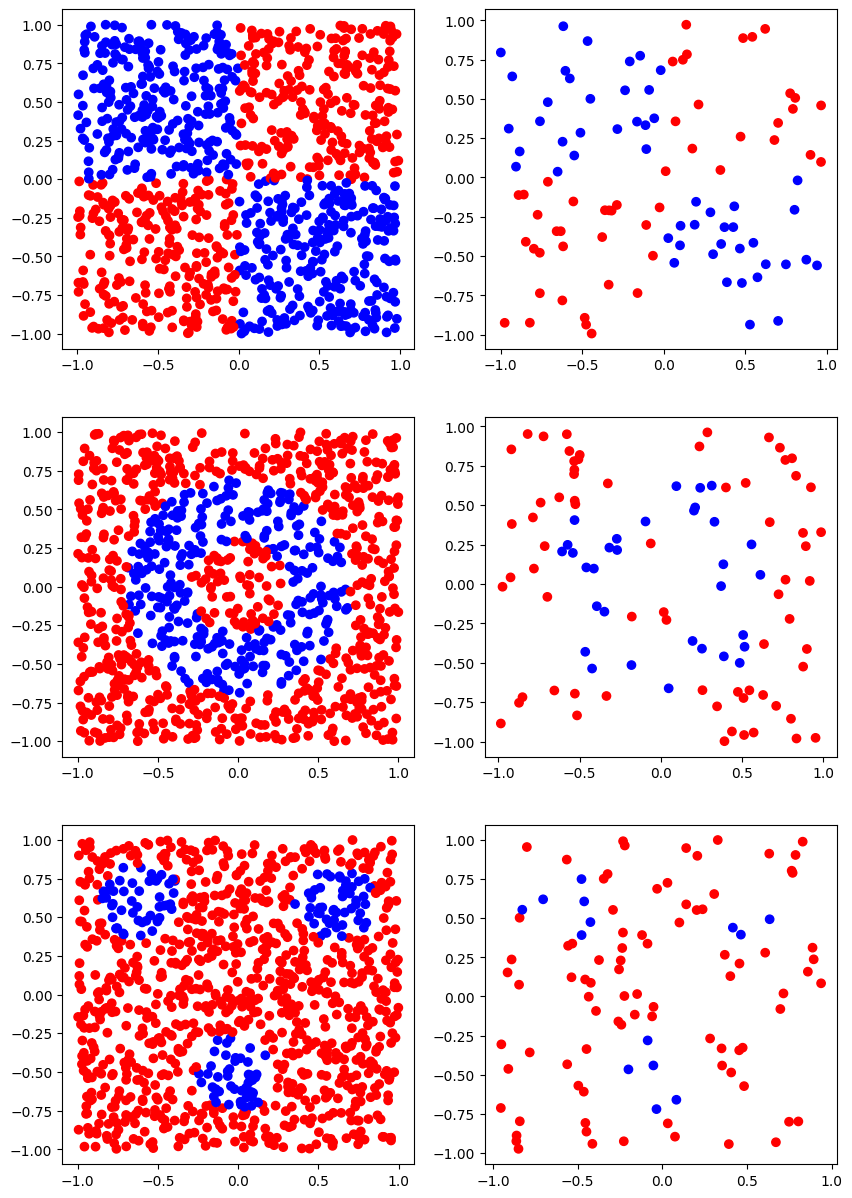

In [7]:
datasets = [
    ("Quadrant XOR", gen_quadrant),
    ("Bublik", gen_bublik),
    ("Three blobs", gen_blobs)
]

loaders = {}
fig, axs = plt.subplots(nrows=len(datasets), ncols=2, figsize=(10, 15))
for i, (name, gen_fn) in enumerate(datasets):
    X_tr, y_tr = gen_fn(N_TRAIN)
    X_va, y_va = gen_fn(N_VAL)
    tr_loader, va_loader = make_loaders(X_tr, y_tr, X_va, y_va)
    loaders[name] = (tr_loader, va_loader)
    
    color_tr = ["red" if y == 0 else "blue" for y in y_tr]
    axs[i][0].scatter(X_tr[:, 0], X_tr[:, 1], c=color_tr)
    
    color_va = ["red" if y == 0 else "blue" for y in y_va]
    axs[i][1].scatter(X_va[:, 0], X_va[:, 1], c=color_va)

# Model Training

In [8]:
def plot_decision_boundary(model, X, y, title="", steps=200, writer=None, global_step=0):
    model.eval()
    xx = np.linspace(-1.1, 1.1, steps)
    yy = np.linspace(-1.1, 1.1, steps)
    grid = np.stack(np.meshgrid(xx, yy), -1).reshape(-1, 2).astype(np.float32)
    
    with torch.no_grad():
        logits = model(torch.from_numpy(grid))
        probs = torch.sigmoid(logits).numpy().reshape(steps, steps)

    fig, ax = plt.subplots(figsize=(6, 6))
    contour = ax.contourf(xx, yy, probs, levels=50, cmap="RdBu", alpha=0.6)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap="RdBu", edgecolors="k", s=30)
    ax.set_title(title)
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    plt.colorbar(contour, ax=ax, label="Probability")
    if writer is not None:
        writer.add_figure(f"Decision Boundary/{title}", fig, global_step=global_step)
    
    plt.close(fig)

In [9]:
def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, name: str):
    opt = torch.optim.AdamW(model.parameters(), lr=LR)
    criterion = nn.BCEWithLogitsLoss()
    
    scheduler = ReduceLROnPlateau(
        opt, 
        mode='min', 
        factor=LR_FACTOR, 
        patience=LR_PATIENCE, 
        min_lr=MIN_LR,
    )

    writer = SummaryWriter(f'runs/{name}')
    global_step = 0
    
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    best_model_state = None

    for ep in range(EPOCHS):
        model.train()
        epoch_train_loss = 0
        num_batches = 0
        
        for i, (xb, yb) in enumerate(train_loader):
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            yb = yb.float().unsqueeze(1)
            loss = criterion(model(xb), yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            epoch_train_loss += loss.item()
            num_batches += 1

            writer.add_scalar('Loss/Train_Batch', loss.item(), global_step)
            
            x_plot, y_plot = val_loader.dataset.tensors
            plot_decision_boundary(model, x_plot.cpu().numpy(), y_plot.cpu().numpy(),
                                title=f"{name}_Batch_{i}_Epoch_{ep}", 
                                writer=writer, global_step=global_step)
            global_step += 1

        avg_train_loss = epoch_train_loss / num_batches

        model.eval()
        with torch.no_grad():
            accum_accuracy = 0
            accum_loss = 0
            for xb_val, yb_val in val_loader:
                xb_val, yb_val = xb_val.to(DEVICE), yb_val.to(DEVICE)
                logits = model(xb_val)
                val_loss = criterion(logits, yb_val.float().unsqueeze(1)).item()
                preds = (torch.sigmoid(logits) > 0.5).int().squeeze(1)
                acc = (preds == yb_val).float().mean().item()
                
                accum_accuracy += acc
                accum_loss += val_loss
            mean_val_loss = accum_loss / len(val_loader)
            mean_val_acc = accum_accuracy / len(val_loader)
            
        scheduler.step(mean_val_loss)
        current_lr = opt.param_groups[0]['lr']
        
        writer.add_scalar('Loss/Train_Epoch', avg_train_loss, ep)
        writer.add_scalar('Loss/Validation', mean_val_loss, ep)
        writer.add_scalar('Accuracy/Validation', mean_val_acc, ep)
        writer.add_scalar('Learning_Rate', current_lr, ep)

        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
            epochs_without_improvement = 0
            best_model_state = model.state_dict().copy()
        else:
            epochs_without_improvement += 1
    
        print(f"{name} | Epoch {ep:02d} | train_loss={avg_train_loss:.4f} | val_loss={mean_val_loss:.4f} | val_acc={mean_val_acc:.4f} | lr={current_lr:.2e}")
        if epochs_without_improvement >= EARLY_STOP_PATIENCE:
            print(f"Early stopping triggered after {ep + 1} epochs. No improvement for {EARLY_STOP_PATIENCE} epochs.")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Restored model to best state with validation loss: {best_val_loss:.4f}")

    x_plot, y_plot = val_loader.dataset.tensors
    plot_decision_boundary(model, x_plot.cpu().numpy(), y_plot.cpu().numpy(),
                        title=f"{name}_Final_Best", 
                        writer=writer, global_step=global_step)
    
    writer.close()
    return best_val_loss

## Linear Model

In [10]:
class LinearModel(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x)

In [11]:
linear_model = LinearModel(input_dim=2, output_dim=1).to(DEVICE)
train_model(linear_model, *loaders["Quadrant XOR"], name="Linear_Model_QuadrantXOR")

Linear_Model_QuadrantXOR | Epoch 00 | train_loss=0.7053 | val_loss=0.6975 | val_acc=0.6606 | lr=1.00e-02
Linear_Model_QuadrantXOR | Epoch 01 | train_loss=0.6990 | val_loss=0.6940 | val_acc=0.6823 | lr=1.00e-02
Linear_Model_QuadrantXOR | Epoch 02 | train_loss=0.6961 | val_loss=0.6940 | val_acc=0.6328 | lr=1.00e-02
Linear_Model_QuadrantXOR | Epoch 03 | train_loss=0.6943 | val_loss=0.6937 | val_acc=0.5816 | lr=1.00e-02
Linear_Model_QuadrantXOR | Epoch 04 | train_loss=0.6935 | val_loss=0.6943 | val_acc=0.4835 | lr=1.00e-02
Linear_Model_QuadrantXOR | Epoch 05 | train_loss=0.6926 | val_loss=0.6943 | val_acc=0.4835 | lr=1.00e-02
Linear_Model_QuadrantXOR | Epoch 06 | train_loss=0.6925 | val_loss=0.6960 | val_acc=0.4835 | lr=1.00e-02
Linear_Model_QuadrantXOR | Epoch 07 | train_loss=0.6929 | val_loss=0.6967 | val_acc=0.4835 | lr=1.00e-02
Linear_Model_QuadrantXOR | Epoch 08 | train_loss=0.6926 | val_loss=0.6958 | val_acc=0.4835 | lr=1.00e-02
Linear_Model_QuadrantXOR | Epoch 09 | train_loss=0.6930

0.6937403082847595

In [12]:
linear_model = LinearModel(input_dim=2, output_dim=1).to(DEVICE)
train_model(linear_model, *loaders["Bublik"], name="Linear_Model_Bublik")

Linear_Model_Bublik | Epoch 00 | train_loss=0.7876 | val_loss=0.7443 | val_acc=0.4453 | lr=1.00e-02
Linear_Model_Bublik | Epoch 01 | train_loss=0.7408 | val_loss=0.7095 | val_acc=0.5217 | lr=1.00e-02
Linear_Model_Bublik | Epoch 02 | train_loss=0.7011 | val_loss=0.6843 | val_acc=0.5191 | lr=1.00e-02
Linear_Model_Bublik | Epoch 03 | train_loss=0.6725 | val_loss=0.6654 | val_acc=0.6710 | lr=1.00e-02
Linear_Model_Bublik | Epoch 04 | train_loss=0.6514 | val_loss=0.6521 | val_acc=0.6710 | lr=1.00e-02
Linear_Model_Bublik | Epoch 05 | train_loss=0.6379 | val_loss=0.6433 | val_acc=0.6710 | lr=1.00e-02
Linear_Model_Bublik | Epoch 06 | train_loss=0.6253 | val_loss=0.6383 | val_acc=0.6710 | lr=1.00e-02
Linear_Model_Bublik | Epoch 07 | train_loss=0.6172 | val_loss=0.6353 | val_acc=0.6710 | lr=1.00e-02
Linear_Model_Bublik | Epoch 08 | train_loss=0.6136 | val_loss=0.6332 | val_acc=0.6710 | lr=1.00e-02
Linear_Model_Bublik | Epoch 09 | train_loss=0.6107 | val_loss=0.6324 | val_acc=0.6710 | lr=1.00e-02


0.6322877109050751

In [13]:
linear_model = LinearModel(input_dim=2, output_dim=1).to(DEVICE)
train_model(linear_model, *loaders["Three blobs"], name="Linear_Model_ThreeBlobs")

Linear_Model_ThreeBlobs | Epoch 00 | train_loss=0.9421 | val_loss=0.9134 | val_acc=0.1458 | lr=1.00e-02
Linear_Model_ThreeBlobs | Epoch 01 | train_loss=0.8660 | val_loss=0.8409 | val_acc=0.1675 | lr=1.00e-02
Linear_Model_ThreeBlobs | Epoch 02 | train_loss=0.7986 | val_loss=0.7763 | val_acc=0.3177 | lr=1.00e-02
Linear_Model_ThreeBlobs | Epoch 03 | train_loss=0.7386 | val_loss=0.7199 | val_acc=0.4123 | lr=1.00e-02
Linear_Model_ThreeBlobs | Epoch 04 | train_loss=0.6858 | val_loss=0.6715 | val_acc=0.5868 | lr=1.00e-02
Linear_Model_ThreeBlobs | Epoch 05 | train_loss=0.6420 | val_loss=0.6305 | val_acc=0.7031 | lr=1.00e-02
Linear_Model_ThreeBlobs | Epoch 06 | train_loss=0.6048 | val_loss=0.5945 | val_acc=0.7422 | lr=1.00e-02
Linear_Model_ThreeBlobs | Epoch 07 | train_loss=0.5724 | val_loss=0.5640 | val_acc=0.8542 | lr=1.00e-02
Linear_Model_ThreeBlobs | Epoch 08 | train_loss=0.5460 | val_loss=0.5390 | val_acc=0.8542 | lr=1.00e-02
Linear_Model_ThreeBlobs | Epoch 09 | train_loss=0.5218 | val_los

0.4124634116888046

## MLP 1 ReLU

In [14]:
class MLP_1(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, output_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

In [15]:
linear_model = MLP_1(input_dim=2, output_dim=1).to(DEVICE)
train_model(linear_model, *loaders["Quadrant XOR"], name="MLP_1_QuadrantXOR")

MLP_1_QuadrantXOR | Epoch 00 | train_loss=0.6941 | val_loss=0.6627 | val_acc=0.5885 | lr=1.00e-02
MLP_1_QuadrantXOR | Epoch 01 | train_loss=0.6417 | val_loss=0.6162 | val_acc=0.7752 | lr=1.00e-02
MLP_1_QuadrantXOR | Epoch 02 | train_loss=0.5861 | val_loss=0.5496 | val_acc=0.8741 | lr=1.00e-02
MLP_1_QuadrantXOR | Epoch 03 | train_loss=0.5197 | val_loss=0.4850 | val_acc=0.8976 | lr=1.00e-02
MLP_1_QuadrantXOR | Epoch 04 | train_loss=0.4550 | val_loss=0.4225 | val_acc=0.9193 | lr=1.00e-02
MLP_1_QuadrantXOR | Epoch 05 | train_loss=0.3922 | val_loss=0.3628 | val_acc=0.9410 | lr=1.00e-02
MLP_1_QuadrantXOR | Epoch 06 | train_loss=0.3324 | val_loss=0.3109 | val_acc=0.9627 | lr=1.00e-02
MLP_1_QuadrantXOR | Epoch 07 | train_loss=0.2844 | val_loss=0.2678 | val_acc=0.9766 | lr=1.00e-02
MLP_1_QuadrantXOR | Epoch 08 | train_loss=0.2471 | val_loss=0.2373 | val_acc=0.9766 | lr=1.00e-02
MLP_1_QuadrantXOR | Epoch 09 | train_loss=0.2210 | val_loss=0.2117 | val_acc=0.9766 | lr=1.00e-02
MLP_1_QuadrantXOR | 

0.022227967157959938

In [16]:
linear_model = MLP_1(input_dim=2, output_dim=1).to(DEVICE)
train_model(linear_model, *loaders["Bublik"], name="MLP_1_Bublik")

MLP_1_Bublik | Epoch 00 | train_loss=0.5912 | val_loss=0.6066 | val_acc=0.6710 | lr=1.00e-02
MLP_1_Bublik | Epoch 01 | train_loss=0.5647 | val_loss=0.5879 | val_acc=0.6710 | lr=1.00e-02
MLP_1_Bublik | Epoch 02 | train_loss=0.5429 | val_loss=0.5612 | val_acc=0.6710 | lr=1.00e-02
MLP_1_Bublik | Epoch 03 | train_loss=0.5192 | val_loss=0.5365 | val_acc=0.6710 | lr=1.00e-02
MLP_1_Bublik | Epoch 04 | train_loss=0.4949 | val_loss=0.5122 | val_acc=0.6710 | lr=1.00e-02
MLP_1_Bublik | Epoch 05 | train_loss=0.4731 | val_loss=0.4877 | val_acc=0.6476 | lr=1.00e-02
MLP_1_Bublik | Epoch 06 | train_loss=0.4513 | val_loss=0.4640 | val_acc=0.6849 | lr=1.00e-02
MLP_1_Bublik | Epoch 07 | train_loss=0.4295 | val_loss=0.4404 | val_acc=0.7361 | lr=1.00e-02
MLP_1_Bublik | Epoch 08 | train_loss=0.4116 | val_loss=0.4175 | val_acc=0.7439 | lr=1.00e-02
MLP_1_Bublik | Epoch 09 | train_loss=0.3945 | val_loss=0.3969 | val_acc=0.7517 | lr=1.00e-02
MLP_1_Bublik | Epoch 10 | train_loss=0.3787 | val_loss=0.3777 | val_ac

0.15039633959531784

In [17]:
linear_model = MLP_1(input_dim=2, output_dim=1).to(DEVICE)
train_model(linear_model, *loaders["Three blobs"], name="MLP_1_ThreeBlobs")

MLP_1_ThreeBlobs | Epoch 00 | train_loss=0.4984 | val_loss=0.4273 | val_acc=0.8542 | lr=1.00e-02
MLP_1_ThreeBlobs | Epoch 01 | train_loss=0.4182 | val_loss=0.4059 | val_acc=0.8542 | lr=1.00e-02
MLP_1_ThreeBlobs | Epoch 02 | train_loss=0.4001 | val_loss=0.4022 | val_acc=0.8542 | lr=1.00e-02
MLP_1_ThreeBlobs | Epoch 03 | train_loss=0.4001 | val_loss=0.4023 | val_acc=0.8542 | lr=1.00e-02
MLP_1_ThreeBlobs | Epoch 04 | train_loss=0.3951 | val_loss=0.4032 | val_acc=0.8542 | lr=1.00e-02
MLP_1_ThreeBlobs | Epoch 05 | train_loss=0.3947 | val_loss=0.3975 | val_acc=0.8542 | lr=1.00e-02
MLP_1_ThreeBlobs | Epoch 06 | train_loss=0.3869 | val_loss=0.3966 | val_acc=0.8542 | lr=1.00e-02
MLP_1_ThreeBlobs | Epoch 07 | train_loss=0.3815 | val_loss=0.3893 | val_acc=0.8542 | lr=1.00e-02
MLP_1_ThreeBlobs | Epoch 08 | train_loss=0.3808 | val_loss=0.3908 | val_acc=0.8542 | lr=1.00e-02
MLP_1_ThreeBlobs | Epoch 09 | train_loss=0.3743 | val_loss=0.3863 | val_acc=0.8542 | lr=1.00e-02
MLP_1_ThreeBlobs | Epoch 10 | 

0.24483845382928848

## MLP 2

In [18]:
class MLP_2(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, output_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

In [19]:
linear_model = MLP_2(input_dim=2, output_dim=1).to(DEVICE)
train_model(linear_model, *loaders["Quadrant XOR"], name="MLP_2_QuadrantXOR")

MLP_2_QuadrantXOR | Epoch 00 | train_loss=0.6758 | val_loss=0.6455 | val_acc=0.6337 | lr=1.00e-02
MLP_2_QuadrantXOR | Epoch 01 | train_loss=0.5597 | val_loss=0.4827 | val_acc=0.8368 | lr=1.00e-02
MLP_2_QuadrantXOR | Epoch 02 | train_loss=0.3657 | val_loss=0.3035 | val_acc=0.9115 | lr=1.00e-02
MLP_2_QuadrantXOR | Epoch 03 | train_loss=0.2372 | val_loss=0.1924 | val_acc=0.9271 | lr=1.00e-02
MLP_2_QuadrantXOR | Epoch 04 | train_loss=0.1737 | val_loss=0.1418 | val_acc=0.9193 | lr=1.00e-02
MLP_2_QuadrantXOR | Epoch 05 | train_loss=0.1303 | val_loss=0.1202 | val_acc=0.9549 | lr=1.00e-02
MLP_2_QuadrantXOR | Epoch 06 | train_loss=0.1114 | val_loss=0.0994 | val_acc=0.9627 | lr=1.00e-02
MLP_2_QuadrantXOR | Epoch 07 | train_loss=0.0934 | val_loss=0.0821 | val_acc=0.9783 | lr=1.00e-02
MLP_2_QuadrantXOR | Epoch 08 | train_loss=0.0846 | val_loss=0.0748 | val_acc=0.9705 | lr=1.00e-02
MLP_2_QuadrantXOR | Epoch 09 | train_loss=0.0777 | val_loss=0.0620 | val_acc=0.9783 | lr=1.00e-02
MLP_2_QuadrantXOR | 

0.01268791314214468

In [20]:
linear_model = MLP_2(input_dim=2, output_dim=1).to(DEVICE)
train_model(linear_model, *loaders["Bublik"], name="MLP_2_Bublik")

MLP_2_Bublik | Epoch 00 | train_loss=0.6161 | val_loss=0.6163 | val_acc=0.6710 | lr=1.00e-02
MLP_2_Bublik | Epoch 01 | train_loss=0.5594 | val_loss=0.5574 | val_acc=0.6710 | lr=1.00e-02
MLP_2_Bublik | Epoch 02 | train_loss=0.5172 | val_loss=0.4993 | val_acc=0.6710 | lr=1.00e-02
MLP_2_Bublik | Epoch 03 | train_loss=0.4657 | val_loss=0.4402 | val_acc=0.6710 | lr=1.00e-02
MLP_2_Bublik | Epoch 04 | train_loss=0.4032 | val_loss=0.3807 | val_acc=0.7361 | lr=1.00e-02
MLP_2_Bublik | Epoch 05 | train_loss=0.3489 | val_loss=0.3260 | val_acc=0.8507 | lr=1.00e-02
MLP_2_Bublik | Epoch 06 | train_loss=0.3072 | val_loss=0.3006 | val_acc=0.8880 | lr=1.00e-02
MLP_2_Bublik | Epoch 07 | train_loss=0.2824 | val_loss=0.2713 | val_acc=0.8880 | lr=1.00e-02
MLP_2_Bublik | Epoch 08 | train_loss=0.2656 | val_loss=0.2659 | val_acc=0.8958 | lr=1.00e-02
MLP_2_Bublik | Epoch 09 | train_loss=0.2542 | val_loss=0.2537 | val_acc=0.8958 | lr=1.00e-02
MLP_2_Bublik | Epoch 10 | train_loss=0.2419 | val_loss=0.2352 | val_ac

0.15450487285852432

In [21]:
linear_model = MLP_2(input_dim=2, output_dim=1).to(DEVICE)
train_model(linear_model, *loaders["Three blobs"], name="MLP_2_ThreeBlobs")

MLP_2_ThreeBlobs | Epoch 00 | train_loss=0.5840 | val_loss=0.4178 | val_acc=0.8542 | lr=1.00e-02
MLP_2_ThreeBlobs | Epoch 01 | train_loss=0.4190 | val_loss=0.4170 | val_acc=0.8542 | lr=1.00e-02
MLP_2_ThreeBlobs | Epoch 02 | train_loss=0.4053 | val_loss=0.4064 | val_acc=0.8542 | lr=1.00e-02
MLP_2_ThreeBlobs | Epoch 03 | train_loss=0.3916 | val_loss=0.3960 | val_acc=0.8542 | lr=1.00e-02
MLP_2_ThreeBlobs | Epoch 04 | train_loss=0.3829 | val_loss=0.3855 | val_acc=0.8542 | lr=1.00e-02
MLP_2_ThreeBlobs | Epoch 05 | train_loss=0.3715 | val_loss=0.3714 | val_acc=0.8542 | lr=1.00e-02
MLP_2_ThreeBlobs | Epoch 06 | train_loss=0.3555 | val_loss=0.3592 | val_acc=0.8542 | lr=1.00e-02
MLP_2_ThreeBlobs | Epoch 07 | train_loss=0.3446 | val_loss=0.3465 | val_acc=0.8542 | lr=1.00e-02
MLP_2_ThreeBlobs | Epoch 08 | train_loss=0.3356 | val_loss=0.3301 | val_acc=0.8542 | lr=1.00e-02
MLP_2_ThreeBlobs | Epoch 09 | train_loss=0.3258 | val_loss=0.3210 | val_acc=0.8542 | lr=1.00e-02
MLP_2_ThreeBlobs | Epoch 10 | 

0.10203826054930687

# Results

Линейная модель не подходит для этих данных
Модель с 1 скрытым слоем справляется на порядок лучше: XOR неплохо апроксимируется
Модель с 2 скрытыми слоями  работает ещё лучше, однако в 3 кругах не хватает параметров